<a href="https://colab.research.google.com/github/DorAzaria/Sentiment-Analysis-Deep-Learning-Methods-For-Speech-Recognition/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/data/')

Mounted at /content/data/


# **IMPORTS**
---

In [2]:
%%capture

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
import pandas as pd
import os
import datetime
import torchaudio
from numpy import mat

!sudo apt-get install libportaudio2
!sudo apt-get install python-scipy

!pip install sounddevice
!pip install scipy

import sounddevice
from scipy.io.wavfile import write

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **PREPROCESS**

---



In [36]:
class Data:

    def __init__(self):
        file_handler = open('/content/data/MyDrive/dl/dataset.pth', 'rb')
        data = pickle.load(file_handler)
        x_dataset = [embedding[1] for embedding in data]
        y_dataset = [label[2] for label in data]
        train_x, test_x, train_y, test_y = train_test_split(np.array(x_dataset), np.array(y_dataset), test_size=0.30)
        self.train_x = torch.from_numpy(train_x)
        self.train_y = torch.from_numpy(train_y)
        torch_train = TensorDataset(self.train_x, self.train_y)
        
        self.test_x = torch.from_numpy(test_x)
        self.test_y = torch.from_numpy(test_y)
        torch_test = TensorDataset(self.test_x, self.test_y)
        

        self.train_loader = DataLoader(torch_train, batch_size=32, drop_last=True, shuffle=True)
        self.test_loader = DataLoader(torch_test, batch_size=32, drop_last=True, shuffle=False)

# **TRAIN**

1, 149, 32
---



In [81]:
DROP_OUT = 0.5
NUM_OF_CLASSES = 3
from datetime import datetime


class ConvNet(nn.Module):

    def __init__(self, num_of_classes, dataset):
        super().__init__()

        # Hyper parameters
        self.epochs = 300
        self.batch_size = 32
        self.learning_rate = 0.001
        self.dataset = dataset

        # Model Architecture
        self.first_conv = nn.Conv2d(1, 96, kernel_size=(5, 5), padding=1) # (96, 147, 30)
        self.first_bn = nn.BatchNorm2d(96)
        self.first_polling = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2)) # (96, 73, 14)

        self.second_conv = nn.Conv2d(96, 256, kernel_size=(5, 5), padding=1) # (256, 71, 12)
        self.second_bn = nn.BatchNorm2d(256)
        self.second_polling = nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1)) # (256, 69, 10)

        self.third_conv = nn.Conv2d(256, 384, kernel_size=(3, 3), padding=1) # (384, 69, 10 )
        self.third_bn = nn.BatchNorm2d(384)

        self.forth_conv = nn.Conv2d(384, 256, kernel_size=(3, 3), padding=1) # (256, 69, 10)
        self.forth_bn = nn.BatchNorm2d(256)

        self.fifth_conv = nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1) # (256, 69, 10)
        self.fifth_bn = nn.BatchNorm2d(256)
        self.fifth_polling = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1)) # (256, 68, 9)

        self.sixth_conv = nn.Conv2d(256, 64, kernel_size=(2, 2), padding=1) # (64, 69, 10)

        self.seventh_conv = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1) # (64, 69, 10)
        self.seventh_polling = nn.MaxPool2d(kernel_size=(2,2), stride=(2, 2)) # (64, 34, 5)

        self.eighth_conv = nn.Conv2d(64, 32, kernel_size=(3,3), padding=1) # (32, 34, 5)
        self.first_drop = nn.Dropout(p=DROP_OUT)

        self.avg_polling = nn.AdaptiveAvgPool2d((1, 1))
        self.first_dense = nn.Linear(32, 1024)
        self.second_drop = nn.Dropout(p=DROP_OUT)

        self.second_dense = nn.Linear(1024, num_of_classes)

    def forward(self, X):
        x = nn.ReLU()(self.first_conv(X))
        x = self.first_bn(x)
        x = self.first_polling(x)

        x = nn.ReLU()(self.second_conv(x))
        x = self.second_bn(x)
        x = self.second_polling(x)

        x = nn.ReLU()(self.third_conv(x))
        x = self.third_bn(x)

        x = nn.ReLU()(self.forth_conv(x))
        x = self.forth_bn(x)

        x = nn.ReLU()(self.fifth_conv(x))
        x = self.fifth_bn(x)
        x = self.fifth_polling(x)

        x = nn.ReLU()(self.sixth_conv(x))

        x = nn.ReLU()(self.seventh_conv(x))
        x = self.seventh_polling(x)

        x = nn.ReLU()(self.eighth_conv(x))

        x = self.first_drop(x)
        x = self.avg_polling(x)

        x = x.view(-1, x.shape[1])  # output channel for flatten before entering the dense layer

        x = nn.ReLU()(self.first_dense(x))
        x = self.second_drop(x)

        x = self.second_dense(x)
        y = nn.LogSoftmax(dim=1)(x)  # consider using Log-Softmax

        return y

    def get_epochs(self):
        return self.epochs

    def get_learning_rate(self):
        return self.learning_rate

    def get_batch_size(self):
        return self.batch_size

    def train_model(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([2.103336921, 3.203278689, 1])).to(device)

        n_total_steps = len(self.dataset.train_loader)

        for epoch in range(self.get_epochs()):
            for i, (embedding, labels) in enumerate(self.dataset.train_loader):

                embedding = embedding.type(torch.FloatTensor)
                labels = labels.type(torch.LongTensor)
            
                labels = labels.to(device)
                embedding = embedding.to(device)

                # Forward pass
                outputs = self.forward(embedding)
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                if i == 74:
                    print(f'Epoch [{epoch + 1}/{self.epochs}], Loss: {loss.item():.4f}')


# **TEST**

---



In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classes = {0: 'positive', 1:'neutral', 2:'negative'}

class TestConvNet:
    def __init__(self, model, dataset):
        self.model = model
        self.dataset = dataset
        self.results = []

    def test(self):

        with torch.no_grad():
            n_correct = 0
            n_samples = 0
            n_class_correct = [0 for i in range(3)]
            n_class_samples = [0 for i in range(3)]
            
            n_class = [0 for i in range(len(self.dataset.test_y))]
            j = 0
            
            
            for embedding, labels in self.dataset.test_loader:
                
                embedding = embedding.type(torch.FloatTensor)
                labels = labels.type(torch.LongTensor)
                labels = labels.to(device)
                embedding = embedding.to(device)
                outputs = self.model(embedding)

                # max returns (value ,index)
                _, predicted = torch.max(outputs, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item()

                for i in range(self.model.batch_size):
                    label = labels[i]
                    pred = predicted[i]
                    if label == pred:
                        n_class_correct[label] += 1
                    n_class_samples[label] += 1
                    n_class[j] = pred.view(-1).detach().cpu().numpy()[0]
                    j += 1

            acc = 100.0 * n_correct / n_samples
            print(f'Accuracy of the network: {acc} %')
            self.results.append(f'Accuracy of the network: {acc} %')

            for i in range(3):
                acc = 100.0 * n_class_correct[i] / n_class_samples[i]
                print(f'Accuracy of {classes[i]}: {acc} %')
                self.results.append(f'Accuracy of {classes[i]}: {acc} %')
            
            return n_class
        # saved_time = datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")
        # file_name = 'result.txt'
        # directory = '/content/data/' + str(saved_time)
        # os.mkdir(directory)

        # with open(directory + "/" + file_name, 'w') as f:
        #     for line in self.results:
        #         f.write(line)
        #         f.write('\n')

        # torch.save(self.model, directory + "/model.pth")


# **Main**

---


## NORM AND INFERENCE

In [68]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)


def inference(file_name):
    SAMPLE_RATE = 16000
    waveform, sample_rate = torchaudio.load(filepath=file_name,  num_frames=SAMPLE_RATE * 3)
    waveform = waveform.view(1, 96000)
    waveform = waveform.to(device)
    
    if (len(waveform[0]) < 48000):
        print(f'less than 3 seconds: {file_name}')

    if sample_rate != bundle.sample_rate:
        waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

    with torch.inference_mode():
        embedding, _ = model(waveform)

    return embedding.unsqueeze(0)


def Norm(X):
    embedding = X.detach().cpu().numpy()
    for i in range(len(embedding)):
        mlist = embedding[0][i]
        embedding[0][i] = 2 * (mlist - np.max(mlist)) / (np.max(mlist) - np.min(mlist)) + 1

    return torch.from_numpy(embedding).to(device)


def recording(name):
    # import sounddevice
    # # from scipy.io.wavefile import write
    # filename = name
    # fps = 16000
    # duration = 3
    # print("Recording ..")
    # recording = sounddevice.rec(int(duration * fps), samplerate = fps, channels = 2)
    # sounddevice.wait()
    # print("Done.")
    # write(filename, fps, recording)
    # return filename + ".wav"
    pass



## START TRAIN

---



In [83]:
aer_dataset = Data()
cnn = ConvNet(3, aer_dataset)
cnn.to(device)
cnn.train_model()
torch.save(cnn, "/model.pth")

Epoch [1/300], Loss: 1.2994
Epoch [2/300], Loss: 1.2210
Epoch [3/300], Loss: 1.1362
Epoch [4/300], Loss: 1.0502
Epoch [5/300], Loss: 1.0413
Epoch [6/300], Loss: 1.0513
Epoch [7/300], Loss: 0.9070
Epoch [8/300], Loss: 1.0094
Epoch [9/300], Loss: 0.8642
Epoch [10/300], Loss: 0.8489
Epoch [11/300], Loss: 1.0507
Epoch [12/300], Loss: 1.1379
Epoch [13/300], Loss: 0.9117
Epoch [14/300], Loss: 1.1008
Epoch [15/300], Loss: 0.9644
Epoch [16/300], Loss: 0.8843
Epoch [17/300], Loss: 0.9975
Epoch [18/300], Loss: 0.8100
Epoch [19/300], Loss: 0.9971
Epoch [20/300], Loss: 1.0202
Epoch [21/300], Loss: 1.0741
Epoch [22/300], Loss: 0.6906
Epoch [23/300], Loss: 0.8557
Epoch [24/300], Loss: 0.7038
Epoch [25/300], Loss: 0.5552
Epoch [26/300], Loss: 1.1137
Epoch [27/300], Loss: 0.6901
Epoch [28/300], Loss: 0.7214
Epoch [29/300], Loss: 0.8721
Epoch [30/300], Loss: 0.4988
Epoch [31/300], Loss: 0.5946
Epoch [32/300], Loss: 0.6310
Epoch [33/300], Loss: 0.6622
Epoch [34/300], Loss: 0.5470
Epoch [35/300], Loss: 0

In [84]:
torch.save(cnn, "/content/data/MyDrive/dl/model2.pth")

## START TEST


Accuracy of the network: 70.1171875 %

Accuracy of positive: 63.80597014925373 %

Accuracy of neutral: 55.367231638418076 %

Accuracy of negative: 77.54749568221071 %

---



In [85]:
test = TestConvNet(cnn, aer_dataset)
n_class = test.test()

Accuracy of the network: 66.6015625 %
Accuracy of positive: 58.208955223880594 %
Accuracy of neutral: 49.438202247191015 %
Accuracy of negative: 75.77854671280276 %


[[159  26  86]
 [ 37 102  47]
 [125  64 402]]


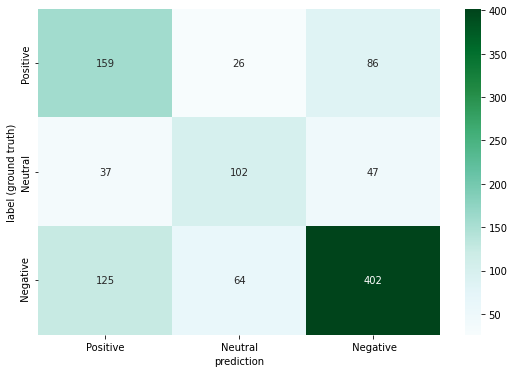

In [71]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Display the confusion matrix as a heatmap
arr = confusion_matrix(aer_dataset.test_y.detach().cpu().numpy(), n_class)
class_names = ['Positive', 'Neutral', ' Negative']
print(arr)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

## INFERENCE

---



In [ ]:
inf_X = inference('/content/data/MyDrive/dl/angry2.wav')
X = Norm(inf_X)
y = cnn.forward(X)
y = y.cpu().detach().numpy()
predict = [np.exp(c) for c in y]
max = np.argmax(predict)
print(predict)
print(classes[max])

[array([9.8371655e-01, 6.2508939e-04, 1.5658503e-02], dtype=float32)]
positive
